In [2]:
# import dependencies
# import sys
# !{sys.executable} -m pip install mpl-scatter-density
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
from scipy.stats import shapiro
import chart_studio as cs
from matplotlib.ticker import PercentFormatter
from scipy.stats import gaussian_kde
import mpl_scatter_density
tf.random.set_seed(42)

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

currently running tensorflow version: 2.8.0


# ML Analysis

In [3]:
# select dataset to analyze

selected_dataset = 'df6'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
    
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df2 = df2.drop(['RGIId', 'region'], axis = 1)
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
    
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df3 = df3.drop(['RGIId', 'region'], axis = 1)
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = 'df3'
    
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df4 = df4.drop(['RGIId', 'region'], axis = 1)
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = 'df4'

if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off',
    )
    df5 = df5.drop(['RGIId', 'region'], axis = 1)
    df5['Zdelta'] = df5['Zmax'] - df5['Zmin']
    module = 'sm5'
    res = 'sr5'
    dataset = df5
    dataset.name = 'df5'
    
if selected_dataset == 'df6':
    df6 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df6 = df6.drop(['RGIId','region'], axis = 1)
    df6['Zdelta'] = df6['Zmax'] - df6['Zmin']
    module = 'sm6'
    res = 'sr6'
    dataset = df6
    dataset.name = 'df6'
    
    
if selected_dataset == 'df7':
    df7 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df7 = df7.drop(['RGIId','region'], axis = 1)
    df7['Zdelta'] = df7['Zmax'] - df7['Zmin']
    module = 'sm7'
    res = 'sr7'
    dataset = df7
    dataset.name = 'df7'
dataset    

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,Zdelta
0,67.91500,18.56400,16.9,1204,1526,1698,1.438,98,1941,72.0,494
1,67.91000,18.49600,15.9,1207,1443,2070,3.696,282,3954,84.0,863
2,67.90300,18.56900,13.2,1143,1414,1797,3.405,102,3636,99.0,654
3,41.41401,-122.21133,21.5,3033,3492,4180,1.291,332,3168,20.0,1147
4,48.75239,-113.72706,17.2,1961,2039,2398,1.018,23,1560,64.0,437
...,...,...,...,...,...,...,...,...,...,...,...
193,77.97140,14.06910,10.1,195,336,521,6.737,56,3780,65.0,326
194,-3.05715,37.35070,9.9,5663,5771,5794,0.616,355,905,23.0,131
195,77.02720,15.48540,18.8,323,422,587,0.418,144,1084,27.0,264
196,78.87100,12.16140,13.8,123,388,684,5.016,350,4111,76.0,561


In [4]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))
print('1/10 inputs = ' + str(0.1 * total_inputs))
print('1/2 inputs = ' + str(0.5 * total_inputs))
non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 4
layer_2 = 4


total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

total inputs = 1980
1/10 inputs = 198.0
1/2 inputs = 990.0
non-trainable parameters = 21
trainable parameters = 69


In [5]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()

for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)

deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains(selected_dataset)) 
#     &
#     (deviations['layer architecture'] == '10-5')
    &
    (deviations['learning rate'] == 0.01)
#     &
#     (deviations['epochs'] == 999)
    &
    (deviations['dropout'] == 1)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
        'layer architecture',
        'test - train',
        'epochs',
        'test mae avg', 
        'train mae avg',
        'test predicted thickness std dev',
        'layer architecture',
        'learning rate',
        'df',
        'layer architecture'
    ]
)
deviations['paramater ratio'] = deviations['trained parameters'] / deviations['total inputs']
deviations

100%|██████████| 3066/3066 [00:00<00:00, 120689.77it/s]


,layer architecture,total parameters,trained parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev,test - train,paramater ratio
25,10-2,156,135,1980,df6,1,0.01,0.2,2000,16.129885,16.212918,2.910639,2.951045,5.924893,2.671601,0.083033,0.068182
42,10-3,168,147,1980,df6,1,0.01,0.2,2000,15.718884,15.756508,3.536094,2.481725,6.003964,2.338725,0.037624,0.074242
58,10-4,180,159,1980,df6,1,0.01,0.2,2000,15.911389,15.562023,4.305880,1.522619,4.692297,2.007323,0.349366,0.080303
73,10-5,192,171,1980,df6,1,0.01,0.2,2000,14.990513,15.148702,2.980817,1.169134,4.925209,1.731755,0.158189,0.086364
87,10-6,204,183,1980,df6,1,0.01,0.2,2000,14.806717,15.082984,3.177192,1.103426,4.694831,1.687066,0.276267,0.092424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,9-4,165,144,1980,df6,1,0.01,0.2,2000,15.039744,15.193521,2.740874,1.127853,5.052029,1.275122,0.153777,0.072727
72,9-5,176,155,1980,df6,1,0.01,0.2,2000,15.955017,15.479413,3.669140,1.825790,5.194475,1.927208,0.475605,0.078283
86,9-6,187,166,1980,df6,1,0.01,0.2,2000,16.343625,16.081445,3.963045,2.946387,4.953086,2.943731,0.262180,0.083838
99,9-7,198,177,1980,df6,1,0.01,0.2,2000,15.126181,15.265874,2.891688,0.868307,5.212321,1.477589,0.139693,0.089394


Text(0.5, 0, 'Trainable parameters / total inputs')

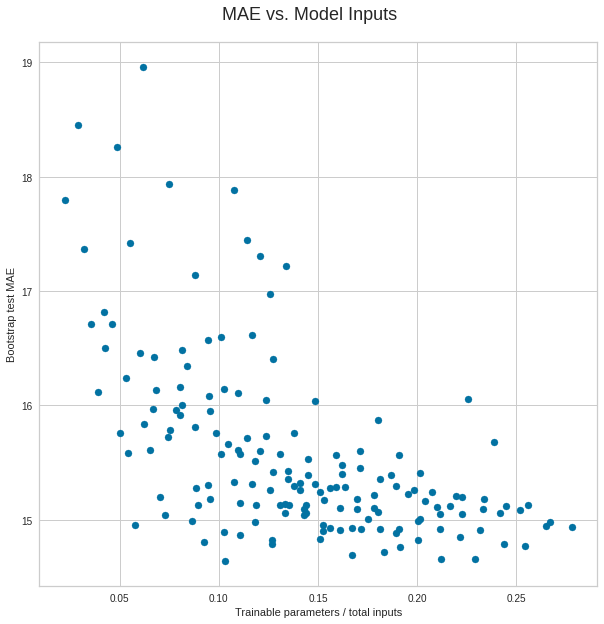

In [37]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('MAE vs. Model Inputs', fontsize=18, y=.93
            )
fig.patch.set_facecolor('w')
plt.scatter(
    deviations['paramater ratio'],
    deviations['test mae avg']
)
# plt.xscale('log')
plt.ylabel('Bootstrap test MAE')
plt.xlabel('Trainable parameters / total inputs')

In [ ]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
training_module = deviations['df'].loc[selection][2:4]
dataset.name = deviations['df'].loc[selection]

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)
fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir_1 = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
fig.suptitle('Loss curves for dataset coregistration ' + training_module +
             ', layer architecture ' + 
             arch + ', learning rate: ' + str(top_learning_rate) 
             )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)
    
    ax.set_title('Random State: ' + str(rs))
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
        gl.plot_loss(dnn_history[model_name])
    
file_name_1 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)

file_name_2 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.svg'
)

plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)



dnn_model = {}
rootdir_2 = 'saved_models/' + module + '/sm_' + arch + '/'

train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using dataset coregistration ' + training_module +
    ', layer architecture ' + arch +
    ', learning rate: ' + str(top_learning_rate)
             , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_history = (
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_history_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )  
    
    model_path = (
        rootdir_2 + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)
    
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
    
        y = dnn_model[model_name].predict(features, verbose = 0)
        plt.plot(labels,y,'.')
        plt.plot(
            (0,400),
            (0,400),
            '-',
            color = 'orange'    
        )
        plt.xlabel('True Thickness (m)')
        plt.ylabel('Model Thickness (m)')
        ax.set_title('Random State ' +str(rs))
        plt.xlim((0,200))
        plt.ylim((0,200))
# plt.tight_layout()

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)
file_name_1 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)
file_name_2 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.svg'
)
plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)

# Predictions Analysis

In [ ]:
predictions = gl.predictions_finder()
predictions = predictions.reset_index()
predictions = predictions.drop('index', axis = 1)
predictions = predictions[predictions['learning rate'] == '0.01']
predictions.sort_values('predicted volume')

In [ ]:
print('mean predicted volume: ' + str(predictions['predicted volume'].mean()))
print('median predicted volume: ' + str(predictions['predicted volume'].median()))
print('predicted volume std dev: ' + str(predictions['predicted volume'].std()))
print('mean predicted std dev std dev: ' + str(predictions['std dev'].median()))

In [ ]:
idx = 122
training_module = predictions['coregistration'].iloc[idx]
architecture = '_' + predictions['architecture'].iloc[idx]
learning_rate = predictions['learning rate'].iloc[idx]
epochs = '2000'

df = gl.regional_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
)

df_global = gl.global_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)

gl.glathida_stats_adder(
    df,
#     pth_1 = '/home/simonhans/data/prethicktor/regional_data/raw/',
#     pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/',
#     pth_3 = '/home/simonhans/data/prethicktor/regional_data/training_data/',
)

In [ ]:
# compute residuals
residuals = df[[
    'dataframe',
    'vol_ratio',
#     'vol_from_zero',
    'voldiff',
]]

residuals['percent error'] = abs(
   ( 1 - residuals['vol_ratio']) * 100
)
residuals['region'] = residuals['dataframe'].str[4:6]
residuals = residuals.drop('dataframe', axis = 1)
residuals.sort_values('percent error')

In [8]:
dft = pd.read_csv('aggregated/sermeq_aggregated_bootstrap_predictions.csv')
ref = pd.read_csv('reference_thicknesses/Farinotti_mean_thickness_RGI_ID_2.csv')
ref = ref[[
    'RGIId',
    'Farinotti Mean Thickness'
]]
ref['region'] = ref['RGIId'].str[6:8]
ref = ref.sort_values('RGIId')
ref = ref.dropna()
RGI = gl.RGI_loader()
RGI = RGI[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

# drops = RGI[
# #     (RGI['Aspect'] < 0) | 
#     (RGI['Zmin'] < 0) |
#     (RGI['Zmax'] < 0) |
#     (RGI['Lmax'] < 0) 

# ].index
# RGI = RGI.drop(drops)
RGI['Zdelta'] = RGI['Zmax'] - RGI['Zmin']
# RGI

ref = pd.merge(ref, RGI, on = 'RGIId')

ref = pd.merge(ref, dft, 
#                left_index = True, right_index = True)
on = [
    'RGIId'
])
ref = ref.rename(columns = {
    'Mean Thickness':'Edasi Mean Thickness'
})

ref['Farinotti Volume'] = (ref['Farinotti Mean Thickness'] / 1e3 )* ref['Area']

ref['region'] = ref['RGIId'].str[6:8]
ref['Edasi Volume'] = (ref['Edasi Mean Thickness'] / 1e3) * ref['Area']
ref['Volume Std Dev'] = (ref['Thickness Std Dev'] / 1e3 )* ref['Area']
ref = ref.reset_index()
ref = ref.drop('index', axis = 1)

ref['VE / VF'] = ref['Edasi Mean Thickness'] / ref['Farinotti Mean Thickness']
ref = ref.drop_duplicates()
ref = ref.dropna()
# sum(ref['volume km3'])
ref

,RGIId,Farinotti Mean Thickness,region,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Zdelta,Unnamed: 0,Edasi Mean Thickness,Median Thickness,Thickness Std Dev,Shapiro-Wilk statistic,Shapiro-Wilk p_value,IQR,Lower Bound,Upper Bound,Median Value,Farinotti Volume,Edasi Volume,Volume Std Dev,VE / VF
0,RGI60-01.00001,21.182035,01,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,789,0,14.841929,14.226050,7.197743,0.974259,1.721300e-27,8.942386,7.885554,21.626253,14.226050,0.007626,0.005343,0.002591,0.700685
1,RGI60-01.00002,30.519478,01,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,431,1,35.318791,35.053523,5.178314,0.966729,9.273571e-31,5.944721,30.864175,39.845612,35.053523,0.017030,0.019708,0.002889,1.157254
2,RGI60-01.00003,35.518610,01,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,573,2,33.070411,32.592387,4.846715,0.958427,9.373772e-34,5.443084,28.916565,37.291615,32.592387,0.059849,0.055724,0.008167,0.931073
3,RGI60-01.00004,53.077263,01,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,1044,3,40.322059,39.819495,5.175665,0.980968,6.835554e-24,6.095077,35.648320,45.116479,39.819495,0.195377,0.148425,0.019052,0.759686
4,RGI60-01.00005,47.519207,01,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,823,4,42.108854,41.651334,5.433712,0.983602,3.243421e-22,6.543149,37.342863,47.168816,41.651334,0.122267,0.108346,0.013981,0.886144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215482,RGI60-19.02748,12.948014,19,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,200,216454,26.798332,24.811207,13.271253,0.961854,1.399892e-32,17.077573,14.143986,39.744851,24.811207,0.000544,0.001126,0.000557,2.069687
215483,RGI60-19.02749,22.894110,19,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,500,216455,37.231512,35.736298,14.775759,0.980468,3.438035e-24,19.285031,23.007389,51.508082,35.736298,0.012981,0.021110,0.008378,1.626249
215484,RGI60-19.02750,60.874610,19,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,1100,216456,73.363529,71.971468,21.894920,0.992775,3.735962e-14,28.705928,52.045433,94.994497,71.971468,0.250682,0.302111,0.090163,1.205158
215485,RGI60-19.02751,10.053704,19,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,100,216457,90.873023,88.635585,25.404969,0.988782,3.084626e-18,33.489690,66.231848,116.174542,88.635585,0.000111,0.001000,0.000279,9.038761


In [11]:
sum_volume = sum(ref['Edasi Volume']) / 1e3
lower_bound = sum(ref['Edasi Volume'] - ((ref['Lower Bound']  / 1e3 )* ref['Area'])) / 1e3
upper_bound = sum(((ref['Upper Bound']  / 1e3 )* ref['Area']) - ref['Edasi Volume']) / 1e3

print(
    f'GTP predicts {sum_volume} + {upper_bound} - {lower_bound} * 10^3 km^3 of ice'
)

GTP predicts 90.55655118044139 + 34.44686377912329 - 37.823396382658935 * 10^3 km^3 of ice


In [33]:
dfp = pd.DataFrame()
for region in tqdm(ref['region'].unique()):
    dfz = ref[ref['region'] == region]
    dfp = pd.concat([dfp, dfz])
    dfp.loc[dfp.index[-1], 'region'] = region
    dfp.loc[dfp.index[-1],  'max VE / VF'] = dfz['VE / VF'].max()
    dfp.loc[dfp.index[-1], 'min VE / VF'] = dfz['VE / VF'].min()
    dfp.loc[dfp.index[-1], 'mean VE / VF'] = dfz['VE / VF'].mean()
    dfp.loc[dfp.index[-1],'median VE / VF'] = dfz['VE / VF'].median()
dfp = dfp.dropna()
dfp = dfp[[
    'region',
    'max VE / VF',
    'min VE / VF',
    'mean VE / VF',
    'median VE / VF'
]]
dfp

100%|██████████| 19/19 [00:00<00:00, 30.15it/s]


,region,max VE / VF,min VE / VF,mean VE / VF,median VE / VF
27107,01,4.836257,0.206789,1.074297,0.989717
45962,02,7.183395,0.329405,1.181546,1.067805
50503,03,8.568498,0.055871,0.971752,0.857287
57918,04,7.034429,0.088202,0.954864,0.840570
77215,05,13.424392,0.088650,1.270494,1.073630
77782,06,2.394802,0.260832,0.994219,0.972025
79397,07,524.340303,0.164780,9.064203,0.878791
82814,08,5.346162,0.387991,1.429455,1.335090
83882,09,3.402238,0.152976,0.856014,0.799415
89021,10,11.503326,0.789739,2.511378,2.285453


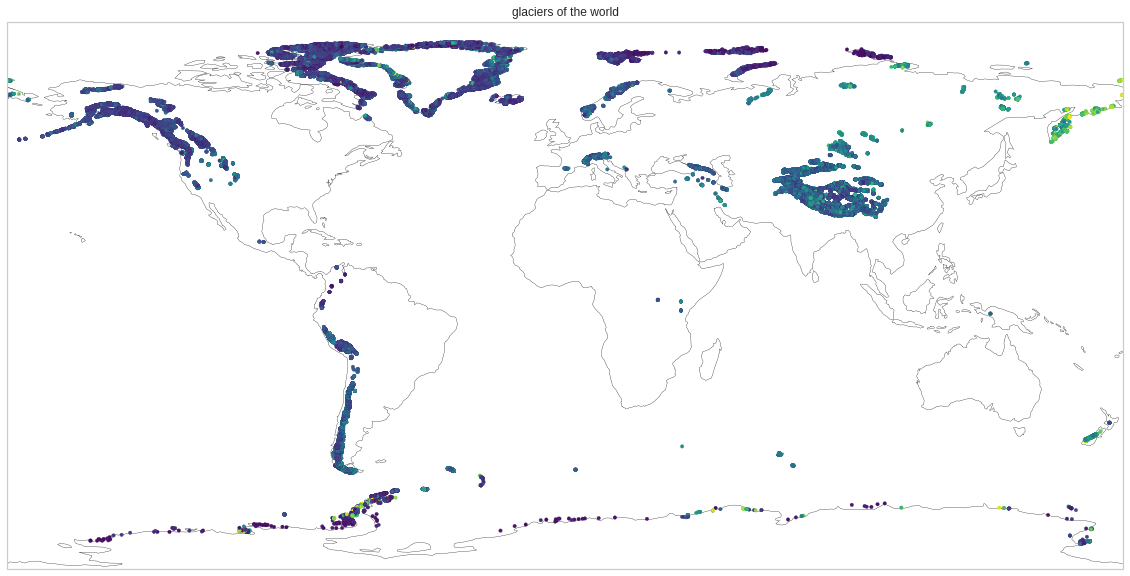

In [78]:
import cartopy.crs as crs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20, 20))
dft = ref[
#         (ref['VE / VF'] >= 25) &
        (ref['VE / VF'] <= 5)
    ]

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
plt.scatter(
    x = dft['CenLon'], 
    y = dft['CenLat'],
    c = dft['VE / VF'],
    cmap = 'viridis',
    marker = '.', 
    alpha = 1

)
ax.set_title('glaciers of the world')
plt.show()
# plt.savefig('figs/cluster/global_map.png')